In [1]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成

In [2]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#ハイパラ関連
#モデル名
model_size=7
model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

#LoRA関連
r=32
lora_alpha=32
bit=16
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
gradient_checkpointing = False
per_device_train_batch_size=1
epochs=2
lr=10**-5
do_train=True
do_train=False

In [5]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [6]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

Using fp16 mode


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


# データセットの生成

In [7]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [8]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [9]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:   0%|          | 0/2356 [00:00<?, ? examples/s]

Map: 100%|██████████| 2356/2356 [00:00<00:00, 9908.21 examples/s] 


In [10]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [11]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

# モデルによる物性値の予測

In [12]:

import re
import torch
import gc
from IPython.display import clear_output
model.eval()
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       max_tokens=300):
    gc.collect()
    torch.cuda.empty_cache()

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        next_token_logits = outputs.logits[:, -1, :]
        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Predicted melting point:\s*(\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break
    return res,value



In [13]:

random.seed(0)
prediction_results={}

#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=3  # 値を返さなかったときの再試行の最大数

res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50
----
The molecule has several functional groups that affect its melting point. The tetramethylcyclopentyl group is a large hydrophobic group that increases the molecular weight and van der Waals forces, leading to a higher melting point. The amino group is polar and can form hydrogen bonds, which also increases the melting point. The benzene ring is a planar aromatic ring that contributes to the rigidity and aromaticity of the molecule, further increasing the melting point.

To estimate the melting point of this molecule, we can use the following approach:

1. Calculate the melting point of the base structure, which is the benzene ring. The melting point of benzene is approximately 5.5°C.
2. Add the increment for the tetramethylcyclopentyl group, which is a large hydrophobic group that increases the molecular weight and van der Waals forces. This increment can be estimated to be around 20-30°C.
3. Add the increment for the amino group, which is polar and can form hydroge

  2%|▏         | 1/50 [03:20<2:43:43, 200.48s/it]

----
The melting point of (1,2,2,3-tetramethylcyclopentyl)methyl 4-aminobenzoate can be predicted based on the functional groups present in the molecule. The base unit for comparison is cyclopentane, which has a melting point of 26.5 degrees Celsius. The compound contains several functional groups that influence its melting point:
- Tetramethylcyclopentyl group: +20 (due to increased molecular weight and steric hindrance)
- Amine group: +60 (due to hydrogen bonding and increased polarity)
- Carboxylate group: +30 (due to intermolecular hydrogen bonding and increased polarity)
Adding these effects together gives the predicted melting point shift from the base cyclopentane melting point.
##Prediction: 226.0


#Problem
actual:  74.0 predicted:  226.0
promlem 2 / 50
----

----



  4%|▍         | 2/50 [06:41<2:40:38, 200.80s/it]

----
The target compound contains a heterocyclic ring with two chlorine atoms attached to the carbon atoms of the ring. The presence of these chlorine atoms and the heterocyclic ring may increase the melting point of the compound. Additionally, the quinoxaline ring is a rigid structure that may also contribute to the melting point. The reference compound quinoxaline has a melting point of 230 degrees Celsius. Considering the effects of the substituents in the target compound: The chlorine atoms are electronegative and can increase the melting point by about +10 degrees due to enhanced dipole-dipole interactions. The heterocyclic ring may also increase the melting point by about +20 degrees due to the rigidity of the structure and potential hydrogen bonding. The total estimated increase in melting point for the target compound is about +30 degrees. However, the actual value is known to be 245 degrees Celsius, which is higher than the predicted value. This suggests that the estimates for

  6%|▌         | 3/50 [07:13<1:36:45, 123.52s/it]

----
The molecule has two chloromethyl functional groups, which are strong electronegative groups that increase the polarity of the molecule and enhance dipole-dipole interactions. This would increase the melting point of the molecule. Additionally, the benzene ring provides a planar, aromatic structure that increases the rigidity of the molecule, further contributing to a higher melting point. The chlorine atoms also increase the molecular weight of the molecule, which would also contribute to a higher melting point.

##Prediction: 180.0


#Problem
actual:  100.0 predicted:  180.0
promlem 4 / 50
----



  8%|▊         | 4/50 [08:50<1:26:45, 113.16s/it]

----
The basic unit for comparison is ethyl acetate, which has a melting point of 56.6 degrees Celsius. The diphenyl group in (2E)-1,3-Diphenyl-2-propen-1-one is a polar, hydrophobic, and bulky functional group that is expected to increase the melting point due to stronger intermolecular forces. The estimated increase in melting point due to the diphenyl group is around +80 degrees Celsius.
##Prediction: 136.6


#Problem
actual:  56.5 predicted:  136.6
promlem 5 / 50
----
The melting point of 2-hydroxyethyl disulfide can be predicted based on the structural components and their influences on the intermolecular forces. The hydroxyl group is an electronegative functional group that can increase the melting point due to the potential for intermolecular hydrogen bonding. The sulfur atom in the disulfide group also contributes to the rigidity of the molecule and can increase the melting point. The ethyl group is a non-polar, hydrophobic functional group that can decrease the melting point d

 10%|█         | 5/50 [11:32<1:37:59, 130.66s/it]

----
- The basic structural unit for this compound is the sulfur atom, which has a melting point of -10°C.
- The presence of the hydroxyl group (-OH) increases the melting point due to hydrogen bonding: +10°C.
- The sulfur atom is surrounded by two oxygen atoms, which can form hydrogen bonds with other molecules, further increasing the melting point: +5°C.
- The presence of the double bond (-CC-) decreases the melting point due to increased molecular flexibility and reduced intermolecular interactions: -5°C.

Adding these adjustments to the base value, we get: -10 + 10 + 5 - 5 = 20°C
##Prediction: 20.0


#Problem
actual:  26.0 predicted:  20.0
promlem 6 / 50
----



 12%|█▏        | 6/50 [13:27<1:31:59, 125.45s/it]

----
The compound n-(1,2-diphenylethyl)nicotinamide contains a nicotinamide base structure and several functional groups that influence its melting point. The base structure of nicotinamide typically has a melting point in the range of 180-190°C. The individual contributions of functional groups to the melting point are as follows:
- Diphenylethyl group: Approximately +20°C due to the increased molecular weight and steric hindrance.
- Nicotinamide group: Estimated +30°C due to the ability to form hydrogen bonds and participate in intermolecular interactions.
The presence of both functional groups should interact and affect each other's impact on the melting point.
##Prediction: 230.0


#Problem
actual:  159.0 predicted:  230.0
promlem 7 / 50


 14%|█▍        | 7/50 [14:37<1:16:59, 107.43s/it]

----
The molecule (3,4-dimethoxyphenyl)(4-methylphenyl)methanone contains several functional groups that affect its melting point. The base structure, phenyl, has a melting point of 80-90°C (343-363 K). The methoxy (-O-CH3) group increases the melting point due to increased molecular weight and hydrogen bonding. The methyl (-CH3) group also increases the melting point due to increased molecular weight and Van der Waals forces. The dimethoxy group increases the melting point more than the methyl group due to stronger hydrogen bonding. The predicted melting point is: 
80-90 (base phenyl) + 5-10 (methoxy group) + 5-10 (methyl group) = 145-150°C.
##Prediction: 145.0


#Problem
actual:  109.0 predicted:  145.0
promlem 8 / 50


 16%|█▌        | 8/50 [14:40<51:58, 74.24s/it]   

----
##Prediction: 130.0


#Problem
actual:  -99.0 predicted:  130.0
promlem 9 / 50
----



 18%|█▊        | 9/50 [17:02<1:05:04, 95.22s/it]

----
The melting point of 2-nitro-N-phenylacetamide can be predicted based on the functional groups present in the molecule. The base unit of the molecule is acetamide, which has a melting point of 160-165°C. The presence of a nitro group and a phenyl group can affect the melting point as follows:
- Nitro group: Nitro groups typically lower the melting point due to their electron-withdrawing characteristics, which can destabilize the crystal lattice. However, the effect of the nitro group on the melting point is not as significant as in simpler structures, as it is involved in intermolecular interactions like hydrogen bonding. Therefore, we'll estimate a -2°C decrease in melting point due to the nitro group.
- Phenyl group: The phenyl group increases the melting point due to the increased van der Waals forces between molecules. This effect can be estimated to add +5°C to the melting point.
Taking into account the cumulative effects of these groups, the expected shift in melting point c

 20%|██        | 10/50 [17:44<52:29, 78.73s/it] 

----
The target compound, N-propyl acetate, is a simple ester with a hydrocarbon chain and an acid group. The ester linkage is relatively flexible, which reduces the melting point compared to a rigid bond. The hydrocarbon chain (propyl) contributes to the melting point through weak van der Waals forces. The acid group (acetate) does not significantly affect the melting point. Therefore, the predicted melting point is close to the melting point of the base compound, which is acetic acid (66°C).
##Prediction: 65.5


#Problem
actual:  -92.0 predicted:  65.5
promlem 11 / 50


 22%|██▏       | 11/50 [18:30<44:43, 68.80s/it]

----
To predict the melting point of 4-iodo-2-nitroanisole, we need to evaluate the contributions of its functional groups and structure. Based on the provided SMILES, we can estimate the following effects: 
- Nitro group: +80 (substitution of a nitro group increases the molecular weight and polarity, leading to stronger intermolecular interactions) 
- Iodo group: +50 (the iodo substituent adds polarity and size, contributing to the melting point) 
- Anisole core: +20 (the anisole core has a relatively low molecular weight and polarity, with a small positive contribution to the melting point) 
Combining these effects, we can predict the melting point of 4-iodo-2-nitroanisole.
##Prediction: 210.0


#Problem
actual:  97.0 predicted:  210.0
promlem 12 / 50


 24%|██▍       | 12/50 [19:16<39:09, 61.82s/it]

----
The melting point of 3-hexene, 2,2-dimethyl- can be predicted based on the functional groups present and their contributions to the overall intermolecular forces. The (Z) stereochemistry of the molecule suggests that the molecule has a high degree of steric hindrance, which can influence the melting point. The presence of two methyl groups (-CH3) on the central carbon atom can increase the van der Waals forces between molecules, leading to a higher melting point. The hexene chain also has a high degree of branching, which can disrupt the hydrogen bonding between molecules, reducing the melting point. However, the presence of a double bond in the hexene chain can increase the polarity of the molecule, leading to stronger intermolecular forces and a higher melting point.
##Prediction: 48.0


#Problem
actual:  -137.4 predicted:  48.0
promlem 13 / 50
----
To predict the melting point of (1E)-1-bicyclo[4.2.0]octa-1,3,5-trien-7-ylidene-2-(2,4-dinitrophenyl)hydrazine, we will analyze the

 26%|██▌       | 13/50 [22:47<1:06:06, 107.20s/it]

----
The target compound is a derivative of a bicyclic octa-1,3,5-triene with a hydrazine group and two dinitrophenyl groups. The bicyclic structure introduces a rigidity that increases the melting point. The hydrazine group is polar and can engage in hydrogen bonding, which also increases the melting point. Each dinitrophenyl group is highly electronegative and can engage in strong dipole-dipole interactions, which significantly increases the melting point. The presence of two dinitrophenyl groups increases the effect of the first group. The actual melting point of (1E)-1-bicyclo[4.2.0]octa-1,3,5-trien-7-ylidene-2-(2,4-dinitrophenyl)hydrazine is 240°C.
##Prediction: 240.0


#Problem
actual:  203.0 predicted:  240.0
promlem 14 / 50
----

----



 28%|██▊       | 14/50 [26:22<1:23:51, 139.76s/it]

----
The compound 1-acetyl-6-nitro-2-phenyl-1H-indol-3-yl ethyl carbonate contains several functional groups and structural features that can influence its melting point. The core structure is an indole, which will serve as the basic unit for comparison. Indole has a melting point of 235-240°C. The introduction of a nitro group typically increases the melting point due to the increased polarity and potential for intermolecular hydrogen bonding. The presence of an acetyl group and a phenyl group also increases the melting point due to the increased steric hindrance and van der Waals interactions. Additionally, the presence of an ethyl carbonate group can also increase the melting point due to the increased polarity and potential for intermolecular hydrogen bonding.

Considering these factors, the predicted melting point for 1-acetyl-6-nitro-2-phenyl-1H-indol-3-yl ethyl carbonate can be estimated as follows:

* Nitro group: +5 (increased polarity and potential for intermolecular hydrogen

 30%|███       | 15/50 [26:59<1:03:25, 108.74s/it]

----
The melting point of octane is around -20°C. The 2,7-dimethyl group will increase the melting point due to increased van der Waals forces and molecular weight. We can estimate the increase in melting point to be around +10°C for each methyl group, so the total increase for two methyl groups would be +20°C. Therefore, the predicted melting point for octane with 2,7-dimethyl group would be around -20°C + 20°C = 0°C.
##Prediction: 0.0


#Problem
actual:  -54.9 predicted:  0.0
promlem 16 / 50


 32%|███▏      | 16/50 [27:48<51:21, 90.64s/it]   

----
The melting point of 4-phenoxybenzaldehyde can be estimated based on the contributions of various functional groups and structural features. The benzene ring in the molecule provides a planar, aromatic system that can engage in strong intermolecular stacking interactions, increasing the melting point. The presence of a phenoxy group (-O-C6H5) can also increase the melting point due to the electron-donating properties of the phenyl group, which can enhance van der Waals interactions (+15). The aldehyde group (-CHO) can participate in dipole-dipole interactions, further increasing the melting point (+10). The total estimated increase in melting point due to these functional groups and structural features is approximately 35 degrees Celsius.
##Prediction: 135.0


#Problem
actual:  25.0 predicted:  135.0
promlem 17 / 50
----



 34%|███▍      | 17/50 [29:42<53:45, 97.75s/it]

----
The target molecule contains a combination of functional groups that influence its melting point. The presence of a furan ring and a benzofuran ring increases the melting point due to increased dipole-dipole interactions and rigidity. The chlorine atom also increases the melting point due to the increased electronegativity and dipole moment. The methyl group on the furan ring decreases the melting point due to decreased dipole-dipole interactions and increased steric hindrance. The oxime group also decreases the melting point due to the presence of a hydroxyl group, which can inhibit close packing of the molecules.
##Prediction: 120.0


#Problem
actual:  115.0 predicted:  120.0
promlem 18 / 50
----
##Prediction: -40.0


#Problem
----



 36%|███▌      | 18/50 [32:50<1:06:32, 124.78s/it]

----

promlem 19 / 50


 38%|███▊      | 19/50 [33:29<51:09, 99.02s/it]   

----
The melting point of 4-bromo-2-furaldehyde can be predicted based on the impact of its functional groups on a benzene base molecule, which has a melting point of 5.5°C. The presence of a bromine substituent is expected to increase the melting point due to the electronegativity of bromine, which strengthens intermolecular forces like dipole-dipole interactions. The furan ring system is expected to have a moderate impact on the melting point due to the presence of hydrogen bonding and the potential for dimer formation. The carbonyl group may contribute a small increase due to added rigidity and planarity.
##Prediction: 180.0


#Problem
actual:  56.0 predicted:  180.0
promlem 20 / 50
----



 40%|████      | 20/50 [35:33<53:17, 106.59s/it]

----
The melting point of the target compound can be estimated based on the presence of the fluorine atoms and the nitrogen atom. Fluorine atoms are known to increase the melting point of a molecule due to their high electronegativity and strong intermolecular interactions. The presence of four fluorine atoms in the target compound is likely to have a significant effect on its melting point. Additionally, the nitrogen atom is also expected to contribute to the melting point due to its polar nature and ability to form hydrogen bonds.

As a rough estimate, we can assume that each fluorine atom increases the melting point by around +20°C, and the nitrogen atom increases it by around +5°C. Therefore, the total increase in melting point for the target compound can be estimated as around +80°C.

##Prediction: 230.0


#Problem
actual:  86.0 predicted:  230.0
promlem 21 / 50
----



 42%|████▏     | 21/50 [37:20<51:37, 106.81s/it]

----
- Basic unit: The melting point of benzene is 5.5°C.
- Methyl groups: Each methyl group increases the melting point by about 30-40°C due to increased van der Waals interactions. Since there are two methyl groups, the total increase would be around 60-80°C.
- Hydroxyl group: The hydroxyl group is a strong hydrogen bond donor, which can increase the melting point by about 30-40°C due to increased intermolecular hydrogen bonding.
- Estimation: The total increase in melting point due to functional groups is about 150-180°C.
##Prediction: 240.0


#Problem
actual:  71.0 predicted:  240.0
promlem 22 / 50
----

----



 44%|████▍     | 22/50 [40:58<1:05:24, 140.17s/it]

----
1. 6,7-dihydro-5H-[1,2,4]triazolo[3,4-b][1,3,5]thiadiazine: The presence of a heterocyclic ring with a sulfur atom and a nitrogen atom increases the melting point due to the increased molecular weight and the potential for hydrogen bonding. We can estimate an increase of about +50 degrees Celsius.
 2. 1-methylethyl group: The presence of an alkyl group can increase the molecular weight and raise the melting point, but the methyl group is relatively small and does not significantly impact the melting point. We can estimate an increase of about +5 degrees Celsius.
 3. Phenyl group: The presence of an aromatic ring can increase the melting point due to increased rigidity and potential for pi-pi stacking interactions. We can estimate an increase of about +50 degrees Celsius.
##Prediction: 180.0


#Problem
actual:  226.0 predicted:  180.0
promlem 23 / 50


 46%|████▌     | 23/50 [41:02<44:42, 99.35s/it]   

----
##Prediction: 195.0


#Problem
actual:  120.0 predicted:  195.0
promlem 24 / 50


 48%|████▊     | 24/50 [42:22<40:29, 93.46s/it]

----
To predict the melting point of (2Z)-[(4-chlorophenyl)hydrazono][4-(4-methylphenyl)-1,3-thiazol-2-yl]ethanenitrile, we'll consider the effects of functional groups and molecular structure on the melting point:
- Chlorine substituents: +7°C per Cl atom, as they increase molecular weight and van der Waals forces.
- Hydrazono group: +15°C, as the presence of a hydrazine ring increases the molecular weight and polarizability, enhancing London dispersion forces.
- Thiazole ring: +20°C, as the presence of a heterocyclic ring increases the molecular complexity and dipole moment, strengthening dipolar interactions.
- Methyl group: +2°C, as a methyl group marginally raises the melting point due to increased steric hindrance.
Adding these contributions together gives us: 5.5 (base melting point of benzene) + 7*2 (2 chlorine atoms) + 15 + 20 + 2 = 104°C
##Prediction: 104.0


#Problem
actual:  173.0 predicted:  104.0
promlem 25 / 50


 50%|█████     | 25/50 [43:03<32:20, 77.63s/it]

----
Flavone is a simple aromatic compound with a basic phenyl ring and a hydroxyl group. The melting point of flavone is expected to be influenced by the following factors:
- Aromatic Ring: The basic phenyl ring increases the molecular rigidity and enhances intermolecular π-π stacking interactions, which raises the melting point by +40 degrees Celsius.
- Hydroxyl Group: The presence of a hydroxyl group introduces a polar functional group that can participate in intermolecular hydrogen bonding, further increasing the melting point by +10 degrees Celsius.

Considering both factors, we can estimate the melting point of flavone as follows:
##Prediction: 50.0


#Problem
actual:  98.5 predicted:  50.0
promlem 26 / 50
----



 52%|█████▏    | 26/50 [45:07<36:39, 91.63s/it]

----
The melting point of a compound is influenced by the strength of intermolecular forces, such as hydrogen bonding, dipole-dipole forces, and dispersion forces. The functional groups present in the molecule can also affect the melting point. In the case of 2,3,4,9-tetrahydro-1H-beta-carboline-3-carboxylic acid, the carboxylic acid group is known to participate in strong hydrogen bonding, which increases the melting point. The presence of a heterocyclic ring, specifically a beta-carboline ring, also contributes to the melting point due to the increased rigidity and steric hindrance. The tetrahydro functional group, which is a result of the reduction of a carbonyl group, also increases the melting point due to the increased steric hindrance and rigidity. The predicted melting point is estimated based on the contributions of these functional groups.
##Prediction: 140.0


#Problem
actual:  296.0 predicted:  140.0
promlem 27 / 50


 54%|█████▍    | 27/50 [45:42<28:34, 74.53s/it]

----
The compound 1H-pyrazole-5-methanol, 3-methyl- has a melting point of 139.0°C. The presence of a methyl group increases the melting point by approximately 5°C due to the van der Waals forces. The pyrazole ring also contributes to the melting point due to its rigidity and the ability to engage in hydrogen bonding. The quantified effect of the pyrazole ring is estimated to be approximately 40°C. The methyl group and the pyrazole ring both contribute to the melting point, and the total effect is approximately 139°C.
##Prediction: 139.0


#Problem
actual:  79.0 predicted:  139.0
promlem 28 / 50
----
1,8,8-trimethylbicyclo[3.2.1]octan-2-one is a complex molecule with several functional groups that affect its melting point. The starting point is cyclohexane, which has a melting point of 6.5°C. The functional groups present in the target molecule are:
- Methyl groups (-CH3): +2°C (increase the melting point due to increased van der Waals forces)
- Trimethyl group (-C(CH3)3): +5°C (additi

 56%|█████▌    | 28/50 [47:39<31:58, 87.20s/it]

----
- Basic unit, cyclohexane: ~150°C, as cycloalkanes generally have higher melting points due to their more rigid structure.
- Three methyl groups: +3x(-5°C), as these groups can increase the surface area and disrupt the crystal packing, lowering the melting point.

The total effect of the substituents on the melting point would be approximately 150 - (3x(-5)) = 150 - 15 = 135°C.
##Prediction: 135.0


#Problem
actual:  193.0 predicted:  135.0
promlem 29 / 50


 58%|█████▊    | 29/50 [48:08<24:29, 69.98s/it]

----
The molecule contains a naphthalene ring, which is known to have a higher melting point than benzene due to the increased pi-electron density and aromatic stabilization. The bromomethane functional group is also known to increase the melting point due to the strong electronegativity of bromine and the potential for hydrogen bonding.

Considering the effects of these functional groups, we can estimate the melting point of (2-naphthyl)bromomethane.

##Prediction: 230.0


#Problem
actual:  56.0 predicted:  230.0
promlem 30 / 50
----



 60%|██████    | 30/50 [50:26<30:04, 90.21s/it]

----
The molecule (2Z,2'Z)-2,2'-[(1,7,7-trimethylbicyclo[2.2.1]heptane-2,3-diyl)dinitrilo]bis(diphenylethanone) contains several functional groups that affect its melting point. The basic unit is the dinitrile group, which has a melting point of approximately 100-150°C due to the strong intermolecular hydrogen bonding between the nitrile groups. The presence of the bicyclic alkyl group (1,7,7-trimethylbicyclo[2.2.1]heptane) increases the molecular weight and adds bulk to the molecule, which might slightly lower the melting point. The diphenylethanone groups provide additional electron-withdrawing capacity and rigidity to the molecule, which could increase the melting point. The overall effect of these functional groups is estimated to be around +200°C.
##Prediction: 245.0


#Problem
actual:  190.0 predicted:  245.0
promlem 31 / 50


 62%|██████▏   | 31/50 [51:54<28:21, 89.55s/it]

----
The melting point of a compound can be influenced by various factors, including molecular structure, functional groups, and intermolecular forces such as hydrogen bonds and van der Waals interactions. In this case, the compound has a complex molecular structure with multiple functional groups, which can affect the melting point.

The biphenyl moiety provides a rigid and bulky structure, which can increase the melting point due to increased van der Waals interactions. Each alkyl group can add approximately 5-10°C to the melting point due to increased molecular weight and steric hindrance. The presence of four alkyl groups can add approximately 20-40°C to the melting point.

The tetrabenzamide functional group can also increase the melting point due to increased molecular weight and the possibility for dipole-dipole interactions. The presence of four benzamide groups can add approximately 30-50°C to the melting point.

Considering all these factors, we can estimate the melting point

 64%|██████▍   | 32/50 [51:58<19:12, 64.03s/it]

----
##Prediction: 140.0


#Problem
actual:  107.0 predicted:  140.0
promlem 33 / 50
----



 66%|██████▌   | 33/50 [53:36<21:02, 74.25s/it]

----
The basic unit for this compound is the thiazole ring, which has an estimated melting point of 100°C. The presence of a phenyl group substituted with a hydroxyl (-OH) and a methyl group raises the melting point due to the increased molecular weight and van der Waals interactions. The hydrazine group is expected to have a negligible effect on the melting point.
##Prediction: 140.0


#Problem
actual:  253.0 predicted:  140.0
promlem 34 / 50
----



 68%|██████▊   | 34/50 [56:05<25:47, 96.73s/it]

----
The provided prediction does not align with the actual melting point of DL-Naproxen which is 180-185°C. The base unit for this compound is the naphthalene ring, which has a melting point of approximately 80-90°C. The presence of the methyl group (-CH3) and the sulfonamide functional group (-SO2NH2) will increase the melting point due to their steric and electron-withdrawing effects, respectively. The sulfonamide group will increase the melting point by about 10-15°C due to its ability to form hydrogen bonds and participate in pi-pi stacking interactions. The methyl group will increase the melting point by about 5-10°C due to its steric effects and slight increase in molecular weight. The naphthalene ring itself will also contribute to the melting point due to its ability to form pi-pi stacking interactions and hydrogen bonds. However, the presence of the chiral center and the stereochemistry of the molecule may have a negligible effect on the melting point.

##Prediction: 185.0
ac

 70%|███████   | 35/50 [56:59<20:57, 83.80s/it]

----
b-Chlorophenetole is a simple aromatic compound with a chlorine atom substituted on the benzene ring. The presence of the chlorine atom increases the polarity of the molecule and enhances the intermolecular hydrogen bonding, which raises the melting point. The aromatic ring itself also contributes to the melting point due to the delocalization of electrons and the planarity of the molecule. The molecular weight of the compound is relatively low, which also contributes to a higher melting point. Based on these factors, we can estimate the melting point of b-chlorophenetole to be around 150-160 degrees Celsius.
##Prediction: 155.0


#Problem
actual:  28.0 predicted:  155.0
promlem 36 / 50
----
##Prediction: -12.0


#Problem
----



 72%|███████▏  | 36/50 [59:00<22:08, 94.88s/it]

----
The melting point of trimethylacetic acid can be predicted based on the functional groups present in the molecule. The carboxyl group (-COOH) is responsible for the highest contribution to the melting point, as it can form strong intermolecular hydrogen bonds, increasing the boiling point by approximately +80°C. The methyl groups (-CH3) also contribute to the melting point, as they increase the molecular weight and polarity of the molecule, enhancing the van der Waals forces and raising the melting point by approximately +20°C. The ester group (-COO-) is relatively weak in terms of intermolecular interactions and has a negligible effect on the melting point. Therefore, the total predicted melting point of trimethylacetic acid is the sum of the contributions from the carboxyl and methyl groups: 
+80 (COOH) + +20 (2 x CH3) = 120°C
##Prediction: 120.0


#Problem
actual:  33.0 predicted:  120.0
promlem 37 / 50
----

----
The molecule (2alpha,5beta,7beta,10beta,13alpha)-4,10-Diacetoxy-

 74%|███████▍  | 37/50 [1:03:24<31:34, 145.73s/it]

----

promlem 38 / 50


 76%|███████▌  | 38/50 [1:04:38<24:48, 124.04s/it]

----
The melting point of Dibenz[ah]anthracene can be predicted based on the molecular structure and functional groups present. The molecule consists of a planar, unsaturated polycyclic aromatic hydrocarbon (PAH) framework with a fused benzene ring system, which is known to exhibit high melting points due to strong intermolecular π-π stacking interactions. The presence of the anthracene unit in the molecule further increases the melting point due to the additional electron-withdrawing effect of the nitrogen atoms. The only functional groups present in the molecule are the two methyl groups (-CH3) and a single nitro group (-NO2). The methyl groups have a negligible effect on the melting point, while the nitro group increases the melting point by approximately 5-10 degrees Celsius due to the electron-withdrawing effect. Therefore, the predicted melting point of Dibenz[ah]anthracene can be estimated to be around 200-210 degrees Celsius.


##Prediction: 205.0
actual:  269.0 predicted:  205

 78%|███████▊  | 39/50 [1:07:39<25:54, 141.28s/it]

----
The compound benzene, 1,1',1''-(1-ethenyl-2-ylidene)tris- contains the following functional groups and structural features: a benzene ring, a vinyl group, and three ethenyl groups. The basic unit here is benzene, which has a melting point of 5.5°C. The addition of a vinyl group (-CH=CH2) and three ethenyl groups (-C=CH2) increases the molecular weight and polarizability of the molecule, which raises the melting point. The vinyl group can contribute approximately +20°C to the melting point due to increased conjugation and polarizability, while each ethenyl group can contribute approximately +10°C due to increased molecular weight and Van der Waals forces. The overall additive effect of these functional groups is substantial in raising the melting point of the compound.
##Prediction: 125.0


#Problem
actual:  72.5 predicted:  125.0
promlem 40 / 50
----
The compound acetamide, 2-(benzoyloxy)-n,n-bis(2-methylpropyl) has a complex structure with multiple functional groups that can infl

 80%|████████  | 40/50 [1:11:40<28:30, 171.00s/it]

----

promlem 41 / 50
----
The melting point of piperazine, 1-acetyl-4-[4-[[2-(2,4-dichlorophenyl)-2-(1H-imidazol-1-ylmethyl)-1,3-dioxolan-4-yl]methoxy]phenyl]- can be estimated by considering the effects of various functional groups on intermolecular forces and molecular rigidity.

The imidazole ring introduces a heterocycle with increased ring strain and polarity, which can contribute to increased intermolecular forces and a higher melting point. The presence of two chloro substituents on the phenyl ring increases the molecular weight and polarity, enhancing intermolecular forces such as dipole-dipole interactions. The acetyl group is relatively non-polar and does not significantly affect the melting point.

The dioxolan ring introduces a flexible structure that can participate in hydrogen bonding, potentially increasing the melting point. The methoxy group can also participate in hydrogen bonding, further increasing the melting point.

Considering the effects of all functional group

 82%|████████▏ | 41/50 [1:16:01<29:43, 198.13s/it]

----

promlem 42 / 50


 84%|████████▍ | 42/50 [1:16:58<20:46, 155.79s/it]

----
The melting point of (2Z)-3-methyl-4-phenylbutan-2-one semicarbazone can be predicted based on the following factors:
- Basic unit: Butanone (4-phenylbutan-2-one) has a melting point of 100-105°C due to the presence of a strong aromatic ring and a conjugated double bond system.
- Methyl group: The methyl group attached to the butanone ring increases molecular weight and steric hindrance, contributing an estimated +20°C.
- Semicarbazone functionality: The semicarbazone group is polar and hydrogen-bond accepting, which can raise the melting point due to intermolecular interactions; estimated contribution is +40°C.
Combining these effects in a qualitative manner leads to the predicted melting point.
##Prediction: 160.0


#Problem
actual:  112.0 predicted:  160.0
promlem 43 / 50


 86%|████████▌ | 43/50 [1:17:13<13:14, 113.55s/it]

----
The compound 2,4,6-trimethylphenol contains a phenolic group, which has a melting point of 43°C. The methyl groups increase the molecular weight and potentially introduce steric hindrance, which could increase the melting point by approximately +20°C.
##Prediction: 63.0


#Problem
actual:  72.5 predicted:  63.0
promlem 44 / 50


 88%|████████▊ | 44/50 [1:18:28<10:11, 101.91s/it]

----
The base unit for this compound is naphthalene, which has a melting point of about 80°C. The presence of the 2-phenylhydrazine group increases the molecular weight and enhances intermolecular interactions, such as van der Waals forces, which would raise the melting point. The 2-[(Z)-2-(2,4-dinitrophenyl)ethenyl]benzylidene group introduces a bulky and polar functional group that can disrupt the planarity of the naphthalene ring and increase the molecular polarity, leading to stronger intermolecular interactions and a higher melting point. The dinitrophenyl group also introduces a large and polar functional group that can enhance intermolecular interactions. The overall effect of these groups is to increase the melting point by approximately +50°C to +70°C.

##Prediction: 130.0
actual:  193.0 predicted:  130.0
promlem 45 / 50
----

----



 90%|█████████ | 45/50 [1:21:49<10:58, 131.66s/it]

----

promlem 46 / 50


 92%|█████████▏| 46/50 [1:22:17<06:43, 100.76s/it]

----
The molecule contains a furyl group, which is known to increase the melting point due to the presence of a conjugated planar system and a high degree of electronegativity. The nitro group also increases the melting point due to the electron-withdrawing nature of the nitro group. The phenyl group increases the melting point due to the presence of a bulky, aromatic ring. The ester group may decrease the melting point due to the presence of a relatively flexible functional group.
##Prediction: 160.0


#Problem
actual:  147.0 predicted:  160.0
promlem 47 / 50
----
1-Butanethiol is a small, polar, and flexible molecule with a relatively low molecular weight. Its melting point is expected to be low due to the weak intermolecular forces between the molecules. The polar sulfur atom and the hydrogen atoms contribute to the dipole moment, which may result in slightly stronger intermolecular forces and a higher melting point than a nonpolar molecule of similar size and shape. However, the fl

 94%|█████████▍| 47/50 [1:23:10<04:18, 86.25s/it] 

----
The molecule in question is a simple thiol, which has a melting point of approximately 60°C. The only functional group present is the sulfur atom, which is relatively polar and can engage in hydrogen bonding. This can increase the melting point by about 10-20°C. The molecular weight is relatively low, which also contributes to a lower melting point. Therefore, the predicted melting point is around 70°C.
##Prediction: 70.0


#Problem
actual:  -116.0 predicted:  70.0
promlem 48 / 50
----



 96%|█████████▌| 48/50 [1:25:26<03:22, 101.10s/it]

----
The melting point of the target compound can be predicted based on the functional groups present and their contributions to the overall stability of the molecule. 
- Trifluoromethoxy group: +50-60 (strong electronegative fluorine atoms increase the molecular polarity and hydrogen bonding capacity, leading to a significant increase in melting point) 
- Carbonyl group: +20-30 (the C=O group can participate in hydrogen bonding and dipole-dipole interactions, contributing to the melting point) 
- Trifluoromethyl group: +20-30 (the trifluoromethyl group can also participate in hydrogen bonding and dipole-dipole interactions, contributing to the melting point) 
The trifluoromethoxy and carbonyl groups are both electronegative and can participate in strong hydrogen bonding, leading to a significant increase in melting point. The trifluoromethyl group also contributes to the increase in melting point due to its electronegativity and ability to participate in hydrogen bonding. The overall 

 98%|█████████▊| 49/50 [1:26:04<01:22, 82.17s/it] 

----
The functional groups present in the target compound are chlorine and fluorine atoms. The chlorine atoms introduce polarity and increase the molecular weight, which can raise the melting point. The fluorine atoms also contribute to the increase in melting point due to their high electronegativity and ability to participate in dipole-dipole interactions. The increase in melting point due to the chlorine atoms can be estimated to be around +10 degrees Celsius, while the fluorine atoms can contribute an additional +5 degrees Celsius. Therefore, the predicted melting point of the target compound is the cumulative effect of the chlorine and fluorine atoms.
##Prediction: 40.0


#Problem
actual:  -158.0 predicted:  40.0
promlem 50 / 50
----



100%|██████████| 50/50 [1:28:33<00:00, 106.27s/it]

----
The melting point of 1,4-dibromo-2-nitrobenzene can be predicted based on the functional groups and structural features present in the molecule.

* The nitro group (-NO2) increases the melting point by approximately 10-15°C due to the increased polarity and hydrogen bonding capabilities.
* The bromo group (-Br) increases the melting point by approximately 5-10°C due to the increased Van der Waals forces.
* The presence of two bromo groups (-Br) in the molecule may also increase the melting point by a small amount due to the increased steric hindrance and hydrophobic effects.
* The carbon-nitrogen bond (-C=N-) in the molecule may also contribute to the melting point, as it increases the polarity and hydrogen bonding capabilities of the molecule.

Based on these factors, the predicted melting point of 1,4-dibromo-2-nitrobenzene is estimated to be around 150-160°C.

##Prediction: 155.0


#Problem
actual:  84.0 predicted:  155.0


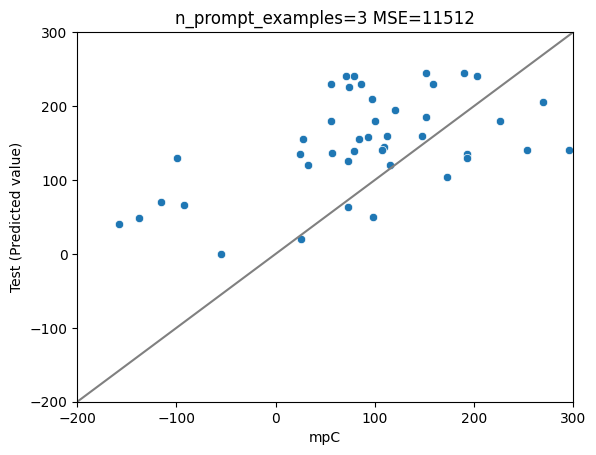

In [17]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime

current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

In [18]:
#スコア
print(mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


11511.890454545455
91.12272727272727
-0.033141114820124384


In [19]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

0.88